<a href="https://colab.research.google.com/github/KonstantinElfimow/E-commerce-A-B-testing-1/blob/main/E_commerce_A_B_testing_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://drive.google.com/file/d/1yqPQKFKRRXKN8CtGktYLA1qWZG8Njq3V/view?usp=sharing

In [ ]:
! gdown --id 1yqPQKFKRRXKN8CtGktYLA1qWZG8Njq3V

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1yqPQKFKRRXKN8CtGktYLA1qWZG8Njq3V
To: /content/archive.zip
100% 3.45M/3.45M [00:00<00:00, 77.1MB/s]


In [ ]:
! unzip /content/archive.zip

Archive:  /content/archive.zip
  inflating: ab_test.csv             
  inflating: countries_ab.csv        


# Загрузка данных / Разведка данных

In [261]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.stats.api as sms
from tqdm.notebook import tqdm

In [262]:
df_ab_test = pd.read_csv('/content/ab_test.csv', sep=',', skipinitialspace=True)
df_countries_ab = pd.read_csv('/content/countries_ab.csv', sep=',', skipinitialspace=True)

In [263]:
# напишем функцию первичяной проверки данных
def check_data(data_df):
  print('\033[1m' + 'Изучим исходные данные' + '\033[0m')
  print(data_df.info())
  # проверим nan
  print('\033[1m' + '\nПроверка пропусков' + '\033[0m')
  print('Количество пропусков:\n{:.0f}'.format(data_df.isnull().sum().sum()))
  print('Доля пропусков:\n{}'.format(data_df.isna().mean()))
  # проверим дубликаты
  print('\033[1m' + '\nПроверка на дубликаты' + '\033[0m')
  print('Количество полных дубликатов:\n', data_df.duplicated().sum())
  # посмотрим на сами данные
  print('\033[1m' + '\nПервые 10 строк датасета' + '\033[0m')
  display(data_df.head(10))

  print('\033[1m' + '\nОписание количественных данных:' + '\033[0m')
  display(data_df.describe(exclude=['object']).T)

  print('\033[1m' + '\nОписание категориальных данных:' + '\033[0m')
  display(data_df.describe(include=['object']).T)

  print('\033[1m' + '\nВывод уникальных значений'\
  ' по каждому категориальному признаку:' + '\033[0m')
  df_objects = data_df.select_dtypes(include='object').columns

  for i in df_objects:
    print('\033[1m' + str(i) + '\033[0m')
    display(data_df[i].value_counts())

In [264]:
check_data(df_ab_test)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         294478 non-null  int64 
 1   time       294478 non-null  object
 2   con_treat  294478 non-null  object
 3   page       294478 non-null  object
 4   converted  294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB
None

Проверка пропусков
Количество пропусков:
0
Доля пропусков:
id           0.0
time         0.0
con_treat    0.0
page         0.0
converted    0.0
dtype: float64

Проверка на дубликаты
Количество полных дубликатов:
 0

Первые 10 строк датасета


,id,time,con_treat,page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1
5,936923,20:49.1,control,old_page,0
6,679687,26:46.9,treatment,new_page,1
7,719014,48:29.5,control,old_page,0
8,817355,58:09.0,treatment,new_page,1
9,839785,11:06.6,treatment,new_page,1



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
id,294478.0,787974.124733,91210.823776,630000.0,709032.25,787933.5,866911.75,945999.0
converted,294478.0,0.119659,0.324563,0.0,0.00,0.0,0.00,1.0



Описание категориальных данных:


,count,unique,top,freq
time,294478,35993,36:26.7,22
con_treat,294478,2,treatment,147276
page,294478,2,old_page,147239



Вывод уникальных значений по каждому категориальному признаку:
time


36:26.7    22
33:53.2    22
02:54.5    21
27:20.8    21
18:31.9    21
           ..
09:36.9     1
21:52.8     1
47:07.1     1
41:10.7     1
52:49.2     1
Name: time, Length: 35993, dtype: int64

con_treat


treatment    147276
control      147202
Name: con_treat, dtype: int64

page


old_page    147239
new_page    147239
Name: page, dtype: int64

Согласно приведённому выше первичному анализу, нужно:
1. Перевести время к виду timedelta и образовать n-количество интервалов, сколько времени проводит клиент на сайте.
2. Можно также перевести con_treat и page, а также converted к dtype category, т.к. значений тут всего по 2 уникальных, а память мы можем сэкономить.

In [265]:
check_data(df_countries_ab)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       290584 non-null  int64 
 1   country  290584 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB
None

Проверка пропусков
Количество пропусков:
0
Доля пропусков:
id         0.0
country    0.0
dtype: float64

Проверка на дубликаты
Количество полных дубликатов:
 0

Первые 10 строк датасета


,id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK
5,909908,UK
6,811617,US
7,938122,US
8,887018,US
9,820683,US



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
id,290584.0,788004.876222,91224.735468,630000.0,709034.75,787995.5,866956.25,945999.0



Описание категориальных данных:


,count,unique,top,freq
country,290584,3,US,203619



Вывод уникальных значений по каждому категориальному признаку:
country


US    203619
UK     72466
CA     14499
Name: country, dtype: int64

Согласно приведённому выше первичному анализу, нужно:
1. Перевести country к dtype category. После можно merge по id c основной таблицей для удобства работы.

# Фильтрация данных / Обработка данных

In [276]:
df_ab_test['time'] = pd.to_datetime(df_ab_test['time'].astype(str).str.strip())

In [272]:
df_ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         294478 non-null  int64 
 1   time       294478 non-null  object
 2   con_treat  294478 non-null  object
 3   page       294478 non-null  object
 4   converted  294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [277]:
df_ab_test['time_intervals'] = pd.cut(df_ab_test['time'], bins=10)

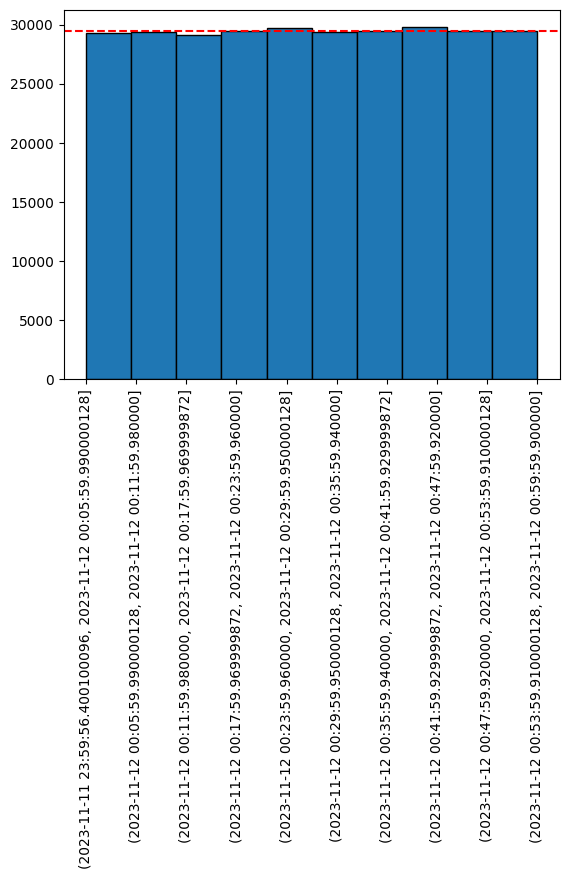

In [278]:
# Построение гистограммы
plt.hist(df_ab_test['time_intervals'].astype(str).sort_values(),
         edgecolor='black')
plt.xticks(rotation=90)  # Поворот подписей на оси x на 90 градусов

# Добавление пунктирной красной линии на ось y, обозначающей среднее ожидаемое значение
mean_value = len(df_ab_test) / len(df_ab_test['time_intervals'].unique())
plt.axhline(y=mean_value, color='r', linestyle='--')

plt.show()

In [279]:
cols = df_ab_test.select_dtypes(include='object').columns
df_ab_test[cols] = df_ab_test[cols].astype('category')
df_ab_test['converted'] = df_ab_test['converted'].astype(bool)

In [280]:
df_ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   id              294478 non-null  int64         
 1   time            294478 non-null  datetime64[ns]
 2   con_treat       294478 non-null  category      
 3   page            294478 non-null  category      
 4   converted       294478 non-null  bool          
 5   time_intervals  294478 non-null  category      
dtypes: bool(1), category(3), datetime64[ns](1), int64(1)
memory usage: 5.6 MB


До этого был memory usage: 11.2+ MB

In [281]:
cols = df_countries_ab.select_dtypes(include='object').columns
df_countries_ab[cols] = df_countries_ab[cols].astype('category')

In [282]:
df_countries_ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype   
---  ------   --------------   -----   
 0   id       290584 non-null  int64   
 1   country  290584 non-null  category
dtypes: category(1), int64(1)
memory usage: 2.5 MB


До этого был memory usage: 4.4+ MB

# Работа с данными

Выясним, как соотносятся группы con_treat и page.

In [283]:
# Объединим датафрейм
df = df_ab_test.merge(df_countries_ab, how='inner', on='id')

In [284]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294478 entries, 0 to 294477
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   id              294478 non-null  int64         
 1   time            294478 non-null  datetime64[ns]
 2   con_treat       294478 non-null  category      
 3   page            294478 non-null  category      
 4   converted       294478 non-null  bool          
 5   time_intervals  294478 non-null  category      
 6   country         294478 non-null  category      
dtypes: bool(1), category(4), datetime64[ns](1), int64(1)
memory usage: 8.1 MB


http://quantile.ru/06/06-Literacy1.pdf
Честно сказать, не очень понял пока что

In [285]:
group_o = df[df['page'] == 'old_page']
table_o = pd.pivot_table(group_o, index=['con_treat'], values='converted', aggfunc='sum')
table_o['size'] = group_o.groupby('con_treat').size()
table_o['cr'] = table_o['converted'] / table_o['size']

In [286]:
table_o

,converted,size,cr
con_treat,,,
control,17489,145274,0.120386
treatment,250,1965,0.127226


In [287]:
es = sms.proportion_effectsize(table_o.loc['control', 'cr'],
                               table_o.loc['treatment', 'cr'])
n = np.ceil(sms.NormalIndPower().solve_power(es,
                                             power=0.8,
                                             alpha=0.05,
                                             ratio=1/74))

count = 100
result = []
group_1 = group_o[group_o['con_treat'] == 'control']['converted']
group_2 = group_o[group_o['con_treat'] == 'treatment']['converted']
for _ in tqdm(range(count)):
  a = group_1.sample(n=int(n), replace=True)
  b = group_2.sample(n=int(n // 74), replace=True)
  pval = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)], alternative='smaller')[1]
  result.append(pval)

  0%|          | 0/100 [00:00<?, ?it/s]

<Axes: ylabel='Count'>

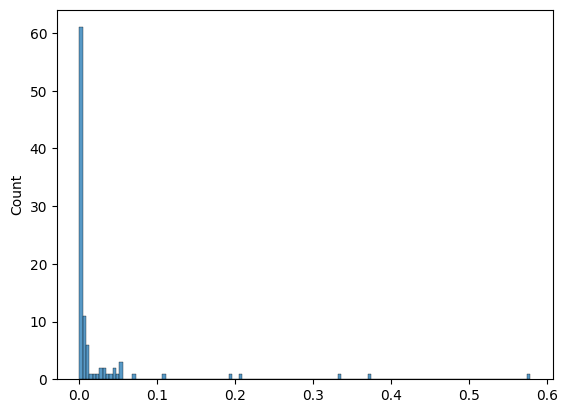

In [288]:
# построение гистограммы для p-value
sns.histplot(result)

На распределении p_value видим, что есть разница между группами есть. Отвергаем H0

Таким образом мы проверили валидность статистической процедуры. Выяснили, что есть основания отвергнуть H0. Эти группы различны.

In [289]:
group_n = df[df['page'] == 'new_page']
table_n = pd.pivot_table(group_n, index=['con_treat'], values='converted', aggfunc='sum')
table_n['size'] = group_n.groupby('con_treat').size()
table_n['cr'] = table_n['converted'] / table_n['size']

In [290]:
table_n

,converted,size,cr
con_treat,,,
control,234,1928,0.121369
treatment,17264,145311,0.118807


In [291]:
es = sms.proportion_effectsize(table_n.loc['control', 'cr'],
                               table_n.loc['treatment', 'cr'])
n = np.ceil(sms.NormalIndPower().solve_power(es,
                                             power=0.8,
                                             alpha=0.05,
                                             ratio=1/75))

count = 100
result = []
group_1 = group_n[group_n['con_treat'] == 'control']['converted']
group_2 = group_n[group_n['con_treat'] == 'treatment']['converted']
for _ in tqdm(range(count)):
  a = group_1.sample(n=int(n), replace=True)
  b = group_2.sample(n=int(n // 75), replace=True)
  pval = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)], alternative='larger')[1]
  result.append(pval)

  0%|          | 0/100 [00:00<?, ?it/s]

<Axes: ylabel='Count'>

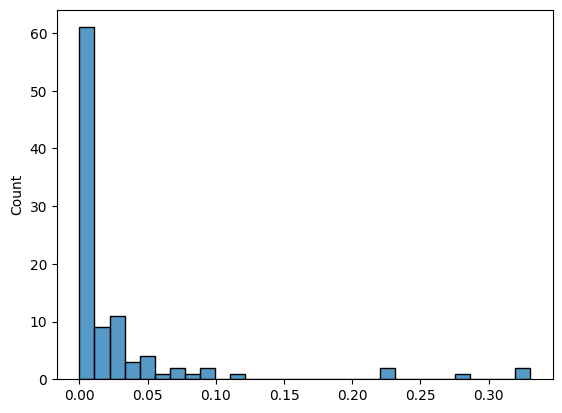

In [292]:
# построение гистограммы для p-value
sns.histplot(result)

Таким образом мы проверили валидность статистической процедуры. Выяснили, что есть основания отвергнуть H0. Эти группы различны.

**Выводы, которые можно сделать**
1. Людям нравится новый лэндинг. Конверсия стала сильно больше.
2. Когда возвращается старый лэндинг, для тех, кто уже знаком с новым - конверсия ухудшается, но не так интенсивно, как возрастала в эксперименте с введением новой странички.